<a href="https://colab.research.google.com/github/mrdobson/SENSIP_2021_REU/blob/main/jpnb/mnist_qnn_10class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
# install platexenc for mpl qcircuit display?
!pip install pylatexenc

In [ ]:
##############################################################################
# QNN Operating on MNIST data set
# Matthew Dobson
# github - https://github.com/mrdobson
# 
##############################################################################
# some of these packages are not necessary, will cull when code is in a better spot
import numpy as np
import matplotlib.pyplot as plt
import time

from torch import tensor
from torch import cat, no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, 
                      MaxPool2d, Flatten, Sequential, ReLU, CrossEntropyLoss)
import torch.optim as optim
import torch.nn.functional as F

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, ADAM

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

In [ ]:
# ---------------
# mode parameters:
#    toggle these to customize behavior of the system
# ---------------
# will eventually turn this into a better "mode select"

#qi = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024)
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

# define number of qubits (max I guess, just trying stuff out)
num_inputs = 4

# number of epochs
epochs = 5

# number of samples for training
n_samp_train = 1000

# for testing
n_samp_test = 400

# Training and Testing Loaders

In [ ]:
# training data load function
def load_training(n_samples=70):
    # returns tuple with X_train.data and X_train.targets <-- what I don't have from iris
    X_train = datasets.MNIST(root='./data', train=True, download=True,
                             transform=transforms.Compose([transforms.ToTensor()]))

    # limit to num_samples of training set
    X_train.data = X_train.data[:n_samples]
    X_train.targets = X_train.targets[:n_samples]
    #### DEBUG
    #print("xtrain data ", X_train.data)
    #print("xtrain targets ", X_train.targets)

    # perform training load
    train_loader = DataLoader(X_train, batch_size=1, shuffle=True)

    # return loader
    return train_loader

In [ ]:
# testing data load function
def load_testing(val_1=0, val_2=1, n_samples=30):
    X_test = datasets.MNIST(root='./data', train=False, download=True,
                            transform=transforms.Compose([transforms.ToTensor()]))

    # limit to num_samples of training set
    X_test.data = X_test.data[:n_samples]
    X_test.targets = X_test.targets[:n_samples]
    #### DEBUG
    #print("xtrain data ", X_test.data)
    #print("xtrain targets ", X_test.targets)

    # perform testing load
    test_loader = DataLoader(X_test, batch_size=1, shuffle=True)

    # return loader
    return test_loader

# Training and Testing Functions

In [ ]:
# function to perform model training
def perform_training(model, optimizer, loss_func, train_loader, epochs=5):
    # start training timer
    start_train = time.time()

    loss_list = [] # store loss history
    model.train()  # place model in training mode
    print('\nBegin training:')

    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True) # init gradient
            output = model(data)             # forward pass
            ### DEBUG
            #print("target is: ", target)
            #print("output is: ", output)
            loss = loss_func(output, target) # calc loss
            loss.backward()                  # backward pass
            optimizer.step()                 # optimize weights
            total_loss.append(loss.item())   # store loss
        loss_list.append(sum(total_loss)/len(total_loss))
        print('Training [{:0f}%]\tLoss: {:.4f}'.format(
              100. * (epoch + 1) / epochs, loss_list[-1]))
        
    # finish training timer, report training runtime
    end_train = time.time()
    print('Training runtime is: ', (end_train - start_train)/60, ' min')
        
    # plot results of cost reduction
    plt.figure()
    plt.plot(loss_list)
    plt.title('Cost Reduction:')
    plt.xlabel('Training Iterations ({0} epochs)'.format(epochs))
    plt.ylabel('Cross Entropy Loss')
    plt.show()

    return total_loss

In [ ]:
# function to test and evaluate model
def perform_eval(model, loss_func, test_loader, total_loss):
    # start eval time
    start_eval = time.time()

    model.eval() # set into eval mode
    print('Begin eval:')

    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
            loss = loss_func(output, target)
            total_loss.append(loss.item())
        # batch_size goes where the 1 is here
        print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
              .format(sum(total_loss) / len(total_loss),
              correct / len(test_loader) / 1 * 100))
    
    # end eval time
    end_eval = time.time()
    print('Evaluation time is: ', (end_eval - start_eval)/60, ' min')

# QNN Definitions

In [ ]:
# data structure to hold QNN objects
qnn_list = []

for i in range(2, num_inputs+1):
    # ZZ is 2nd order Pauli expansion circuit
    # pauli feature map - pass
    fm = ZZFeatureMap(i)
    #fm.draw(output='mpl')

    # RealAmplitudes is used as an ansatz for ML, heuristic trial wave func
    # efficient SU2
    ansatz = RealAmplitudes(i, reps=4)
    #ansatz.draw(output='mpl')

    # define observable
    observable = PauliSumOp.from_list([('Z'*i, 1)])
    #print(observable)

    # define two layer QNN
    qnn = TwoLayerQNN(i, 
                      feature_map=fm, 
                      ansatz=ansatz, 
                      observable=observable,
                      quantum_instance=qi)
    #print(qnn.operator)
    
    # append the QNN object to our data structure
    qnn_list.append(qnn)

# validate, might not work though?
# should contain objects for 2, 3 and 4 qubit QNN circuits
print(len(qnn_list))
print(qnn_list)

3
[<qiskit_machine_learning.neural_networks.two_layer_qnn.TwoLayerQNN object at 0x7fa1666aff50>, <qiskit_machine_learning.neural_networks.two_layer_qnn.TwoLayerQNN object at 0x7fa165efe150>, <qiskit_machine_learning.neural_networks.two_layer_qnn.TwoLayerQNN object at 0x7fa165e6c250>]


# Neural Network

In [ ]:
# legitimately don't know how else to do this but create three separate classes
# to make it work with qiskit, but also I am an amateur at this

# stupid simple solution I guess
class Net2(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 3, kernel_size=5)
        self.conv2 = Conv2d(3, 32, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(512, 128)
        self.fc2 = Linear(128, 2)         # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn_list[0])
        self.fc3 = Linear(1, 10)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.cpu()
        #print('x type is: ', type(x))
        x = self.qnn(x)  # apply QNN
        # typecast qnn output to a cuda tensor
        #x = x.type(dtype=torch.cuda.FloatTensor)
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

class Net3(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 3, kernel_size=5)
        self.conv2 = Conv2d(3, 32, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(512, 128)
        self.fc2 = Linear(128, 3)         # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn_list[1])
        self.fc3 = Linear(1, 10)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.cpu()
        #print('x type is: ', type(x))
        x = self.qnn(x)  # apply QNN
        # typecast qnn output to a cuda tensor
        #x = x.type(dtype=torch.cuda.FloatTensor)
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

class Net4(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 3, kernel_size=5)
        self.conv2 = Conv2d(3, 32, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(512, 128)
        self.fc2 = Linear(128, 4)         # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn_list[2])
        self.fc3 = Linear(1, 10)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.cpu()
        #print('x type is: ', type(x))
        x = self.qnn(x)  # apply QNN
        # typecast qnn output to a cuda tensor
        #x = x.type(dtype=torch.cuda.FloatTensor)
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

model2 = Net2()
model3 = Net3()
model4 = Net4()

In [ ]:
# define model, optimizer and loss function
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)

loss_func = CrossEntropyLoss()

# Main Program (2 qubit)

Begin 2 qubit

Begin training:


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode

Training [20.000000%]	Loss: 3.0736
Training [40.000000%]	Loss: 2.6469
Training [60.000000%]	Loss: 2.4884
Training [80.000000%]	Loss: 2.4140
Training [100.000000%]	Loss: 2.3427
Training runtime is:  16.74954427878062  min


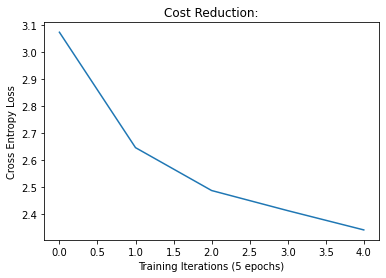

Begin eval:
Performance on test data:
	Loss: 2.3411
	Accuracy: 20.0%
Evaluation time is:  0.006042067209879557  min
2Qubit - Total program runtime is:  16.759840846061707  min


In [ ]:
# total program runtime
start_eval = time.time()
print("Begin 2 qubit")

# data load
trn_load = load_training(n_samp_train)
tst_load = load_testing(n_samp_test)

# train 2 qubit
tot_loss2 = perform_training(model2, optimizer2, loss_func, trn_load, epochs)

# eval 2 qubit
perform_eval(model2, loss_func, tst_load, tot_loss2)

# end eval time
end_eval = time.time()
print('2Qubit - Total program runtime is: ', (end_eval - start_eval)/60, ' min')

# Main Program (3 qubit)

Begin 3 qubit

Begin training:
Training [20.000000%]	Loss: 2.2978
Training [40.000000%]	Loss: 2.3028
Training [60.000000%]	Loss: 2.3062
Training [80.000000%]	Loss: 2.3042
Training [100.000000%]	Loss: 2.3007
Training runtime is:  16.285771254698435  min


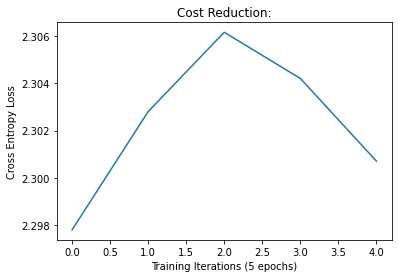

Begin eval:
Performance on test data:
	Loss: 2.3003
	Accuracy: 20.0%
Evaluation time is:  0.005397244294484457  min
3Qubit - Total program runtime is:  16.293797111511232  min


In [ ]:

# total program runtime
start_eval = time.time()
print("Begin 3 qubit")

# train 3 qubit
tot_loss3 = perform_training(model2, optimizer3, loss_func, trn_load, epochs)

# eval 3 qubit
perform_eval(model2, loss_func, tst_load, tot_loss3)

# end eval time
end_eval = time.time()
print('3Qubit - Total program runtime is: ', (end_eval - start_eval)/60, ' min')

# Main Program (4 qubit)

Begin 4 qubit

Begin training:
Training [20.000000%]	Loss: 2.3033
Training [40.000000%]	Loss: 2.3035
Training [60.000000%]	Loss: 2.2984
Training [80.000000%]	Loss: 2.3021
Training [100.000000%]	Loss: 2.2996
Training runtime is:  16.194825887680054  min


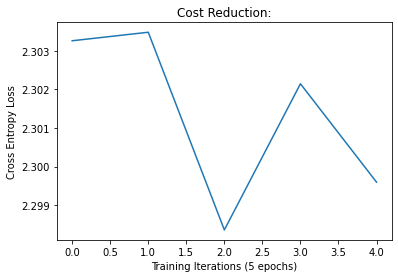

Begin eval:
Performance on test data:
	Loss: 2.2992
	Accuracy: 20.0%
Evaluation time is:  0.00573887825012207  min
4Qubit - Total program runtime is:  16.20314642985662  min


In [ ]:
# total program runtime
start_eval = time.time()
print("Begin 4 qubit")

# train 3 qubit
tot_loss4 = perform_training(model2, optimizer4, loss_func, trn_load, epochs)

# eval 3 qubit
perform_eval(model2, loss_func, tst_load, tot_loss4)

# end eval time
end_eval = time.time()
print('4Qubit - Total program runtime is: ', (end_eval - start_eval)/60, ' min')